# Introduction

In this notebook, I will explore different machine learning methods and convolutional neural networks to predict handwritten digits using the famous MNIST data set (http://yann.lecun.com/exdb/mnist/).

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns; sns.set()
from keras.datasets import mnist
from sklearn.metrics import confusion_matrix

Load and rescale the data:

In [3]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
dim_x, dim_y = 28, 28
x_train = x_train.reshape(60000,dim_x * dim_y)
x_test = x_test.reshape(10000,dim_x * dim_y)
x_train = x_train.astype("float32")
x_test = x_test.astype("float32")
x_train /= 255
x_test /= 255

In [4]:
print(np.unique(y_train, return_counts=True)[1])
print(np.unique(y_test, return_counts=True)[1])

[5923 6742 5958 6131 5842 5421 5918 6265 5851 5949]
[ 980 1135 1032 1010  982  892  958 1028  974 1009]


There are about 6000 samples of each digit on the training set, and 1000 samples on the test set, so both training and testing data are well-balanced. Let's have a look at the digits:

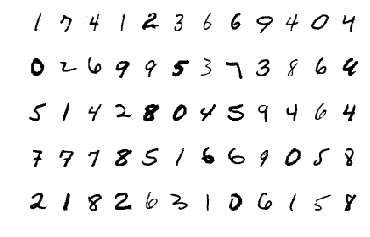

In [5]:
a, b = 5, 12
fig, ax = plt.subplots(a, b)
for i in range(a):
    for j in range(b):
        ax[i,j].imshow(1 - x_train[np.random.randint(0,x_train.shape[0])].reshape(dim_x, dim_y), cmap="gray")
        ax[i,j].axis("off")

While the vast majority are obvious, some of the digits certainly are very ambiguous and are hard to classify even for a human. Let's see how a machine performs.

#### Logistic regression

In [6]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
logreg.fit(x_train, y_train)
logreg.score(x_test, y_test)

0.9201

We get about 92% accuracy. Tinkering with the $C$ value doesn't seem to affect the result significantly. Here is the confusion matrix.

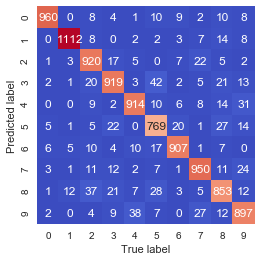

In [7]:
sns.heatmap(confusion_matrix(y_test, logreg.predict(x_test)).T, square=True,
            annot=True, fmt="d", cbar=False, cmap="coolwarm")
plt.xlabel("True label")
plt.ylabel("Predicted label");

Logistic regression is good at recognizing some digits (0 and 1), but is really confused with others (especially 8 and 9).

#### Support vector classifier

In [8]:
from sklearn.svm import SVC
svc = SVC(kernel="linear")
svc.fit(x_train, y_train)
svc.score(x_test, y_test)

0.9404

Better result, but still not very good. We can do better.

#### Random forest

In [9]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=100)
rfc.fit(x_train, y_train)
rfc.score(x_test, y_test)

0.9692

Accuracy of about 97%. 

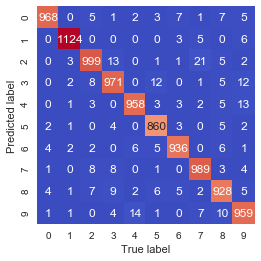

In [10]:
sns.heatmap(confusion_matrix(y_test, rfc.predict(x_test)).T, square=True,
            annot=True, fmt="d", cbar=False, cmap="coolwarm")
plt.xlabel("True label")
plt.ylabel("Predicted label");

Random forest is doing really well. Most of the errors are probably due to rotations, thickness of the digit, digits not being exactly centered, parts of the digit cut off, etc., but also the overall ambiguity of some of the digits.

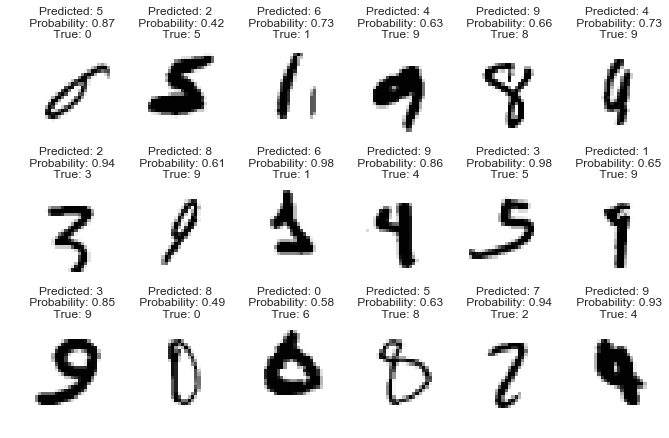

In [11]:
predictions = rfc.predict(x_test)
errors = predictions[y_test != predictions]
x_errors = x_test[y_test != predictions]
y_errors = y_test[y_test != predictions]
rfcprob = logreg.predict_proba(x_errors)
a, b = 3, 6
fig, ax = plt.subplots(a, b)
for i in range(a):
    for j in range(b):
        k = np.random.randint(x_errors.shape[0])
        ax[i,j].imshow(1 - x_errors[k].reshape(dim_x, dim_y), cmap="gray")
        ax[i,j].set_title("Predicted: {}\n Probability: {}\n True: {}".format(errors[k], np.max(rfcprob[k]).round(2), y_errors[k]))
        ax[i,j].axis("off")
fig.subplots_adjust(right=1.6, top=1.5)

Here are some examples. Convolutional neural networks are better at capturing these more general features.

#### CNN

In [12]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import to_categorical

batch_size = 128
epochs = 10

In [13]:
x_train = x_train.reshape(60000,dim_x, dim_y, 1)
x_test = x_test.reshape(10000,dim_x, dim_y, 1)
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

Our CNN contains following layers:
*  a convolutional layer with 5x5 kernel and 32 layers,
*  a max pooling layer,
*  a convolutional layer with 5x5 kernel and 64 layers,
*  another max pooling layer,
*  a dropout layer to avoid overfitting during training,
*  a dense layer with 128 nodes,
*  another dropout layer,
*  and a dense layer with 10 nodes.

In [14]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(5, 5), activation="relu", input_shape=(dim_x, dim_y, 1)))
model.add(MaxPooling2D(pool_size=2, strides=2))
model.add(Conv2D(64, (5, 5), activation="relu"))
model.add(MaxPooling2D(pool_size=2, strides=2))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(10, activation="softmax"))

model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adadelta(), metrics=['accuracy'])

model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 39s 644us/step - loss: 0.2727 - acc: 0.9153 - val_loss: 0.0522 - val_acc: 0.9825
Epoch 2/10
60000/60000 [==============================] - 38s 638us/step - loss: 0.0866 - acc: 0.9742 - val_loss: 0.0352 - val_acc: 0.9879
Epoch 3/10
60000/60000 [==============================] - 38s 639us/step - loss: 0.0623 - acc: 0.9817 - val_loss: 0.0292 - val_acc: 0.9906
Epoch 4/10
60000/60000 [==============================] - 38s 638us/step - loss: 0.0505 - acc: 0.9852 - val_loss: 0.0242 - val_acc: 0.9914
Epoch 5/10
60000/60000 [==============================] - 38s 640us/step - loss: 0.0451 - acc: 0.9863 - val_loss: 0.0221 - val_acc: 0.9921
Epoch 6/10
60000/60000 [==============================] - 38s 639us/step - loss: 0.0397 - acc: 0.9876 - val_loss: 0.0189 - val_acc: 0.9933
Epoch 7/10
60000/60000 [==============================] - 38s 639us/step - loss: 0.0369 - acc: 0.9889 - val_loss: 0.

About 99.4% accuracy, which is very good! CNNs are unbeateble at image recognition. We could get a little bit better by increasing epochs, but for now we are content with this result.